In [1]:
using BenchmarkTools

include("./base.jl")

to_newick_recursive (generic function with 1 method)

In [8]:
## spot check to_newick_recursive with 1000 leaves including sampling
@benchmark to_newick_recursive(sample_v(nleaves)) setup=(nleaves=1_000)

BenchmarkTools.Trial: 6630 samples with 1 evaluation.
 Range (min … max):  482.000 μs …  12.676 ms  ┊ GC (min … max): 0.00% …  0.00%
 Time  (median):     666.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   747.802 μs ± 377.710 μs  ┊ GC (mean ± σ):  6.72% ± 11.47%

   ▅▇███▇▆▆▅▄▃▂▂▁▁▁▁                                            ▂
  █████████████████████▇▇▇▆▅▅▅▁▁▁▄▃▁▃▁▁▁▁▁▁▃▄▁▁▃▁▁▃▅▆▆▆█▇▇▇▅▇▅▇ █
  482 μs        Histogram: log(frequency) by time       2.68 ms <

 Memory estimate: 914.64 KiB, allocs estimate: 10026.

## Benchmark

In [13]:
MIN_LEAVES = 5
MAX_LEAVES = 1000
STEP_LEAVES = 50

N_TIMES = 100
N_REPEATS = 7;

all_leaves = MIN_LEAVES:STEP_LEAVES:MAX_LEAVES |> collect;

### Julia

In [14]:
perfs_jl_itr = zeros(length(all_leaves))
perfs_jl_rec = zeros(length(all_leaves))

for (i, nleaves) in enumerate(all_leaves)
    # compile
    to_newick(sample_v(nleaves))
    to_newick_recursive(sample_v(nleaves))
    
    # bench
    res_itr = @benchmark to_newick(          sample_v(nleaves)) setup=(nleaves=$nleaves) samples=N_TIMES * N_REPEATS
    res_rec = @benchmark to_newick_recursive(sample_v(nleaves)) setup=(nleaves=$nleaves) samples=N_TIMES * N_REPEATS
    
    # convert ns to ms and take mean of evaluations
    perfs_jl_itr[i] = mean(res_itr.times) / 1e6
    perfs_jl_rec[i] = mean(res_rec.times) / 1e6
end

In [2]:
using PyPlot

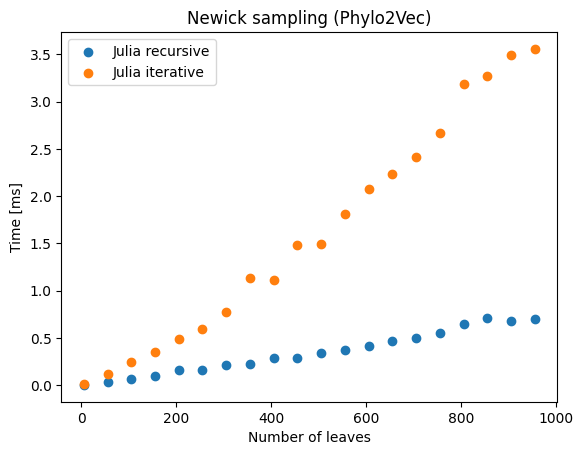

In [15]:
clf()

scatter(all_leaves, perfs_jl_rec, label="Julia recursive")
scatter(all_leaves, perfs_jl_itr, label="Julia iterative")

title("Newick sampling (Phylo2Vec)"); xlabel("Number of leaves"); ylabel("Time [ms]")
legend()

gcf()

### Python

In [7]:
using PyCall

# rebuild package if needed to use Python executable of correct env
# ENV["PYTHON"] = "C:\\Users\\...\\phylo2vec_dev\\.conda\\python.exe"
# import Pkg; Pkg.build("PyCall")

In [9]:
py"""
# minimum version of benchmark

import numpy as np
from phylo2vec.base import to_newick, to_vector
from phylo2vec.utils import sample

import timeit
import pandas as pd

MIN_LEAVES, MAX_LEAVES, STEP_LEAVES = 5, 1000, 50
N_TIMES = 100
N_REPEATS = 7

def sample_p2v(all_leaves):
    print("Benchmark phylo2vec.utils.sample...")

    perfs = np.zeros((len(all_leaves), N_REPEATS))

    for i, n_leaves in enumerate(all_leaves):
        # Compile
        _ = sample(n_leaves)
        _ = to_newick(sample(n_leaves))

        all_runs = np.array(
            timeit.repeat(
                f"to_newick(sample({n_leaves}))",
                "from phylo2vec.base import to_newick; from phylo2vec.utils import sample;"
                f"v = sample({n_leaves}); nw = to_newick(sample({n_leaves}));",
                number=N_TIMES,
                repeat=N_REPEATS,
            )
        )

        perfs[i, :] = all_runs

    return pd.Series(np.mean(perfs / N_TIMES, 1)).rename("Phylo2Vec")

all_leaves = np.arange(MIN_LEAVES, MAX_LEAVES, STEP_LEAVES)
"""

In [10]:
perfs_py = py"""sample_p2v(all_leaves).values * 1000""";

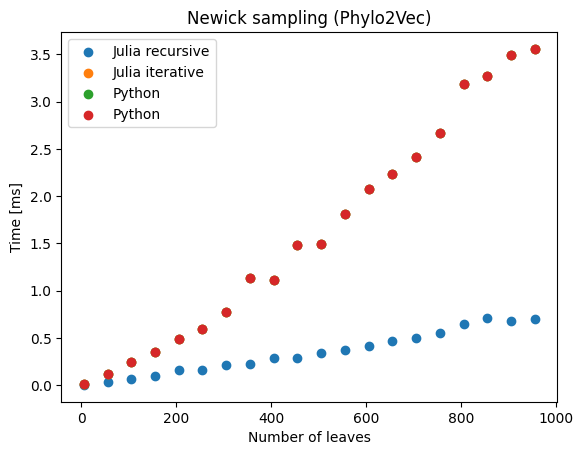

In [17]:
# compare to Julia
scatter(all_leaves, perfs_py, label="Python")
legend()
gcf()